In [146]:
import numpy as np
import matplotlib.pyplot as plt
import re
import os

# Image functions
from skimage.color import rgb2hsv
from skimage.segmentation import slic, mark_boundaries
from prep_image import prep_im_and_mask
from matplotlib.colors import rgb_to_hsv
from scipy.stats import circmean, circvar
from math import nan
from statistics import variance, stdev

In [30]:
im_path = 'test_images' + os.sep
mask_path = 'test_images_masks' + os.sep
im_id = 'PAT_875_1668_588.png'

im, mask = prep_im_and_mask(im_id, im_path, mask_path)

print(im)

[[[0.72156864 0.6784314  0.654902  ]
  [0.72156864 0.6784314  0.654902  ]
  [0.73333335 0.69803923 0.67058825]
  ...
  [0.7137255  0.6745098  0.6666667 ]
  [0.72156864 0.6745098  0.67058825]
  [0.7372549  0.6745098  0.6784314 ]]

 [[0.7058824  0.6666667  0.65882355]
  [0.7254902  0.6862745  0.6745098 ]
  [0.7372549  0.7019608  0.6745098 ]
  ...
  [0.72156864 0.65882355 0.6627451 ]
  [0.7254902  0.6784314  0.6745098 ]
  [0.7254902  0.6784314  0.6745098 ]]

 [[0.7176471  0.6784314  0.6666667 ]
  [0.7254902  0.6862745  0.6745098 ]
  [0.7372549  0.69803923 0.6862745 ]
  ...
  [0.7294118  0.6666667  0.67058825]
  [0.7294118  0.68235296 0.6784314 ]
  [0.7411765  0.6784314  0.68235296]]

 ...

 [[0.59607846 0.57254905 0.5568628 ]
  [0.5882353  0.5647059  0.54509807]
  [0.6        0.5764706  0.54901963]
  ...
  [0.6627451  0.5921569  0.5803922 ]
  [0.6627451  0.5921569  0.5803922 ]
  [0.654902   0.58431375 0.57254905]]

 [[0.5921569  0.5686275  0.54901963]
  [0.58431375 0.56078434 0.54509807]


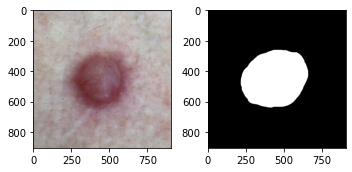

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(im)
axes[1].imshow(mask, cmap='gray')
fig.tight_layout()

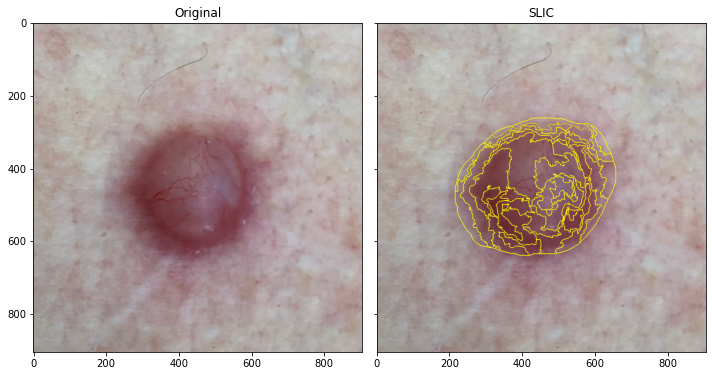

In [140]:
def segments(image, mask, n_segments = 50, compactness = 0.1):
    '''Get color segments of lesion from SLIC algorithm. 
    Optional argument n_segments (defualt 50) defines desired amount of segments.
    Optional argument compactness (defualt 0.1) defines balance between color 
    and position.

    Args:
        image (numpy.ndarray): image to segment
        mask (numpy.ndarray):  image mask
        n_segments (int, optional): desired amount of segments
        compactness (float, optional): compactness score, decides balance between
            color and and position

    Returns:
        slic_segments (numpy.ndarray): SLIC color segments.
    '''
    slic_segments = slic(image,
                    n_segments = n_segments,
                    compactness = compactness,
                    sigma = 1,
                    mask = mask,
                    start_label = 0,
                    channel_axis = 2)
    
    return slic_segments

slic_segments = segments(im, mask)

# Show the results
fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0].imshow(im)
ax[0].set_title("Original")

ax[1].imshow(mark_boundaries(im, slic_segments))
ax[1].set_title('SLIC')

plt.tight_layout()
plt.show()

In [143]:
def get_rgb_means(image, slic_segments):
    '''Get mean RGB values for each segment in a SLIC segmented image.

    Args:
        image (numpy.ndarray): original image
        slic_segments (numpy.ndarray): SLIC segmentation

    Returns:
        rgb_means (list): RGB mean values for each segment.
    '''

    max_segment_id = np.unique(slic_segments)[-1]

    rgb_means = []

    for i in range(1, max_segment_id + 1):

        #Create masked image where only specific segment is active
        segment = image.copy()
        segment[slic_segments != i] = 0

        #Get average RGB values from segment
        rgb_mean = np.mean(segment, axis = (0, 1), where = (segment != 0))
        
        rgb_means.append(rgb_mean)    
        
    return rgb_means

In [126]:
def get_hsv_means(image, slic_segments):
    '''Get mean HSV values for each segment in a SLIC segmented image.

    Args:
        image (numpy.ndarray): original image
        slic_segments (numpy.ndarray): SLIC segmentation

    Returns:
        hsv_means (list): HSV mean values for each segment.
    '''

    hsv_image = rgb2hsv(image)

    max_segment_id = np.unique(slic_segments)[-1]

    hsv_means = []
    
    for i in range(1, max_segment_id + 1):

        # Create masked image where only specific segment is active
        segment = hsv_image.copy()
        segment[slic_segments != i] = nan

        #Get average HSV values from segment
        hues = segment[:, :, 0] # Take only hue channel
        hue_mean = circmean(hues, high=1, low=0, nan_policy='omit') # Compute circular hue mean
        sat_mean = np.mean(segment[:, :, 1], where = (slic_segments == i)) # Compute saturation mean
        val_mean = np.mean(segment[:, :, 2], where = (slic_segments == i)) # Compute value mean

        hsv_mean = np.asarray([hue_mean, sat_mean, val_mean])

        hsv_means.append(hsv_mean)
        
    return hsv_means

In [148]:
def rgb_var(image, slic_segments):
    '''Segment image from image and SLIC segmentation and get variance
    of the mean color values of each segment for red, green and blue channels. 

    Args:
        image (numpy.ndarray): image to compute color variance for
        slic_segments (numpy.ndarray): array containing SLIC segmentation
    
    Returns:
        red_var (float): variance in red channel segment means
        green_var (float): variance in green channel segment means
        blue_var (float): variance in green channel segment means.
    '''

    # If there is only 1 slic segment, return (0, 0, 0)
    if len(np.unique(slic_segments)) == 2: # Use 2 since slic_segments also has 0 for area outside mask
        return 0, 0, 0

    rgb_means = get_rgb_means(image, slic_segments)
    n = len(rgb_means) # Amount of segments, used later to compute variance

    # Seperate and collect channel means together in lists
    red = []
    green = []
    blue = []
    for rgb_mean in rgb_means:
        red.append(rgb_mean[0])
        green.append(rgb_mean[1])
        blue.append(rgb_mean[2])

    # Compute variance for each channel seperately
    red_var = variance(red, sum(red)/n)
    green_var = variance(green, sum(green)/n)
    blue_var = variance(blue, sum(blue)/n)

    return red_var, green_var, blue_var

In [ ]:
def hsv_var(image, slic_segments):
    '''Get variance of HSV means for each segment in 
    SLIC segmentation in hue, saturation and value channels

    Args:
        image (numpy.ndarray): image to compute color variance for
        slic_segments (numpy.ndarray): array containing SLIC segmentation
    
    Returns:
        hue_var (float): variance in hue channel segment means
        sat_var (float): variance in saturation channel segment means
        val_var (float): variance in value channel segment means.
    '''

    # If there is only 1 slic segment, return (0, 0, 0)
    if len(np.unique(slic_segments)) == 2: # Use 2 since slic_segments also has 0 marking for area outside mask
        return 0, 0, 0

    hsv_means = get_hsv_means(image, slic_segments)
    n = len(hsv_means) # Amount of segments, used later to compute variance

    # Seperate and collect channel means together in lists
    hue = []
    sat = []
    val = []
    for hsv_mean in hsv_means:
        hue.append(hsv_mean[0])
        sat.append(hsv_mean[1])
        val.append(hsv_mean[2])

    # Compute variance for each channel seperately
    hue_var = circvar(hue, high=1, low=0)
    sat_var = variance(sat, sum(sat)/n)
    val_var = variance(val, sum(val)/n)

    return hue_var, sat_var, val_var

def hsv_var()

In [144]:
rgb_means = get_rgb_means(im, slic_segments)

hsv_means = [rgb_to_hsv(rgb_mean) for rgb_mean in rgb_means]

hsv_means2 = get_hsv_means(im, slic_segments)

print(rgb_means)
print(hsv_means)
print(hsv_means2)


[array([0.62086135, 0.48756894, 0.47870475], dtype=float32), array([0.6539867, 0.5240897, 0.5310416], dtype=float32), array([0.58677065, 0.42474017, 0.41429457], dtype=float32), array([0.61322093, 0.45612296, 0.48016143], dtype=float32), array([0.6993972 , 0.6021079 , 0.61577207], dtype=float32), array([0.5275071 , 0.36703882, 0.38032013], dtype=float32), array([0.6089008 , 0.45132488, 0.48200518], dtype=float32), array([0.5110053 , 0.3284502 , 0.35590452], dtype=float32), array([0.56417084, 0.37888616, 0.42742658], dtype=float32), array([0.52984506, 0.3585797 , 0.3932942 ], dtype=float32), array([0.61058813, 0.5251047 , 0.5319644 ], dtype=float32), array([0.52117574, 0.30189583, 0.3333962 ], dtype=float32), array([0.46531415, 0.25427315, 0.2725789 ], dtype=float32), array([0.5378907, 0.3800689, 0.421571 ], dtype=float32), array([0.56955683, 0.46527487, 0.48751915], dtype=float32), array([0.52357525, 0.37211308, 0.44464174], dtype=float32), array([0.51140475, 0.33870712, 0.39877617], d

In [13]:
np.unique(segments_slic)

array([0, 1, 2, 3, 4, 5, 6])

In [14]:
im.shape

(904, 905, 3)

In [15]:
np.unique(mask)

array([0, 1])

## Test

In [6]:
data = np.array([i.strip().split(';') for i in open('col_asym.csv')])

In [7]:
mask = data == ''
data[np.where(mask)] = np.nan

img_ids = data[1:,0]
feature_annotations = np.asarray(data[1:,1:], dtype=float)

In [8]:
regex = ".png"
for i in range(len(img_ids)):
    img_ids[i] = re.sub(regex, '', img_ids[i])

In [29]:
color_segments = []
segments_slics = {}

for i in range(10):
    if (img_ids[i] != 'PAT_1989_4061_934' and img_ids[i] != 'PAT_1995_4080_695'):

        im, gt = prep_im_and_gt(img_ids[i], 'test_images/', 'test_image_groundtruths/', 0.25)

        segments_slic = color(im, gt)
        segments_slics[img_ids[i]]=[im, gt, segments_slic]
        color_segments.append(len(np.unique(segments_slic))-1)

In [316]:
color_segments

[3, 3, 3, 3, 3, 3, 3, 3]

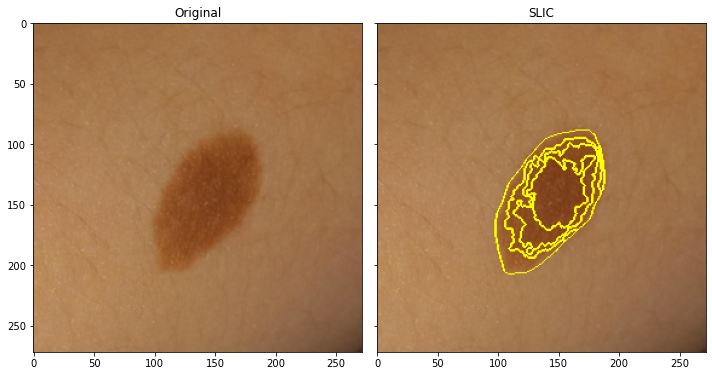

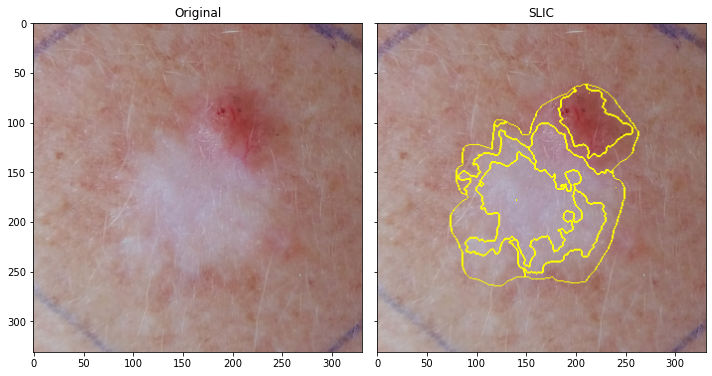

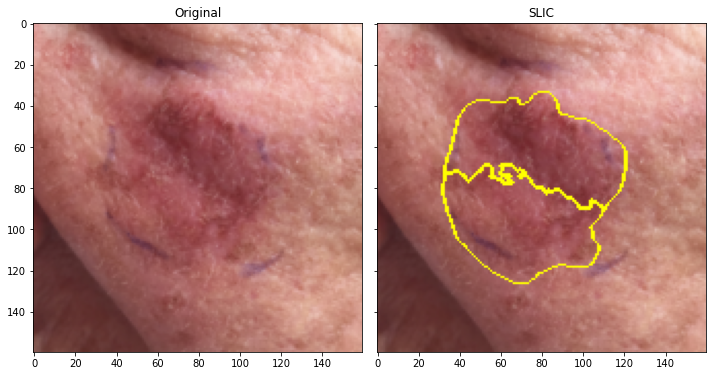

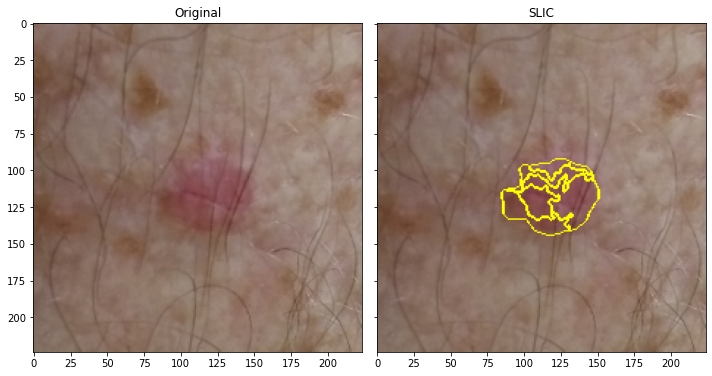

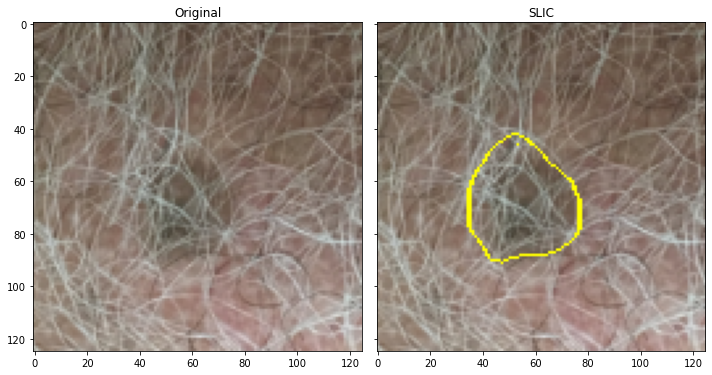

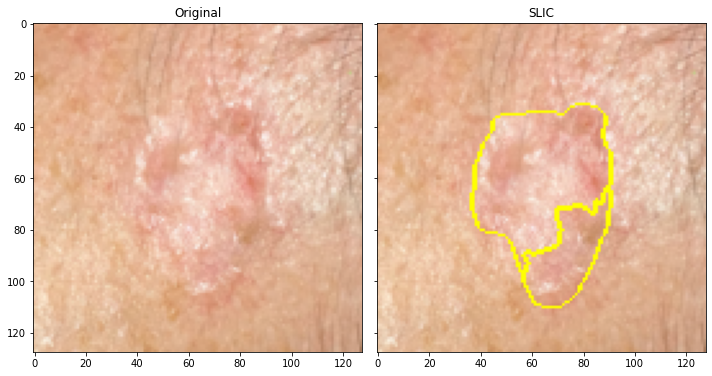

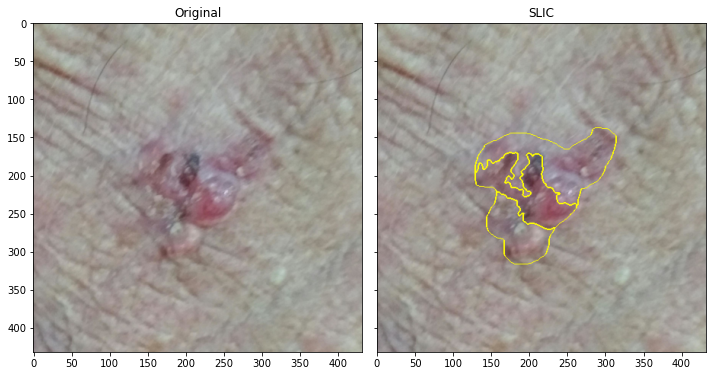

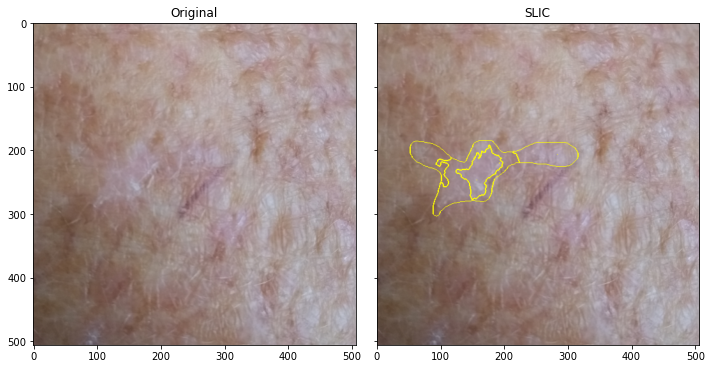

In [30]:
for i in range(10):
    if (img_ids[i] != 'PAT_1989_4061_934' and img_ids[i] != 'PAT_1995_4080_695'):

        fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)

        ax[0].imshow(segments_slics[img_ids[i]][0])
        ax[0].set_title("Original")

        ax[1].imshow(mark_boundaries(segments_slics[img_ids[i]][0], segments_slics[img_ids[i]][2]))
        ax[1].set_title('SLIC')

        plt.tight_layout()
        plt.show()